# Библиотеки

In [1]:
import neptune
import cv
import model_selection_classification
import nn_model
import nn_training
import preprocessing
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
rcParams['figure.figsize'] = 20, 10

In [2]:
%load_ext autoreload
%autoreload 2

Инициализация клиента neptune (neptune.ai)

In [3]:
neptune.init('iliaavilov/Magnit-test')

Project(iliaavilov/Magnit-test)

# Константы

In [4]:
random_state = 54321
data_path = 'data/'

# Загрузка данных

In [5]:
data = pd.read_csv('{}data_classification_for_task.csv'.format(data_path))

# EDA

In [6]:
data.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
for col in data.columns:
    print('Уникальных значений в колонке {}'.format(col), len(data[col].unique()))

Уникальных значений в колонке AGE 41
Уникальных значений в колонке GENDER 2
Уникальных значений в колонке FEATURE_1 4
Уникальных значений в колонке FEATURE_2 49
Уникальных значений в колонке FEATURE_3 152
Уникальных значений в колонке FEATURE_4 2
Уникальных значений в колонке FEATURE_5 3
Уникальных значений в колонке FEATURE_6 91
Уникальных значений в колонке FEATURE_7 2
Уникальных значений в колонке FEATURE_8 40
Уникальных значений в колонке FEATURE_9 3
Уникальных значений в колонке FEATURE_10 5
Уникальных значений в колонке FEATURE_11 4
Уникальных значений в колонке TARGET 2


Отделим категориальные колонки от непрерывных

In [9]:
cont_vars = ['AGE', 'FEATURE_2', 'FEATURE_3', 'FEATURE_6', 'FEATURE_8']
cat_vars = [col for col in data.columns if col not in cont_vars]

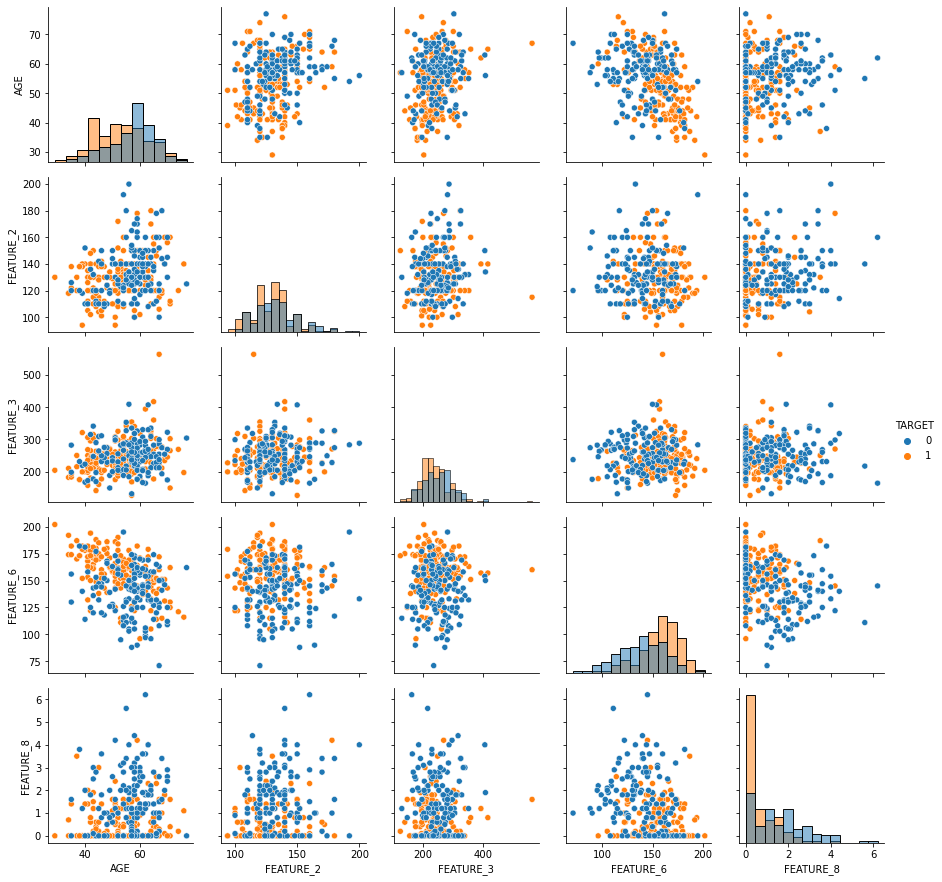

In [10]:
g = sns.PairGrid(data, vars = cont_vars, hue="TARGET")
_ = g.map_diag(sns.histplot)
_ = g.map_offdiag(sns.scatterplot)
_ = g.add_legend()

На некоторых графиках видны намеки на нелинейную границу разделения классов (например график AGE-FEATURE_6)\
Также виден выброс в FEATURE_3 (экстремально большое значение), удалим его

In [11]:
data['FEATURE_3'].sort_values()

111    126
301    131
53     141
151    149
267    149
      ... 
96     394
220    407
246    409
28     417
85     564
Name: FEATURE_3, Length: 303, dtype: int64

In [12]:
data = data[data.index != 15].reset_index(drop = True)

<AxesSubplot:xlabel='FEATURE_3', ylabel='Count'>

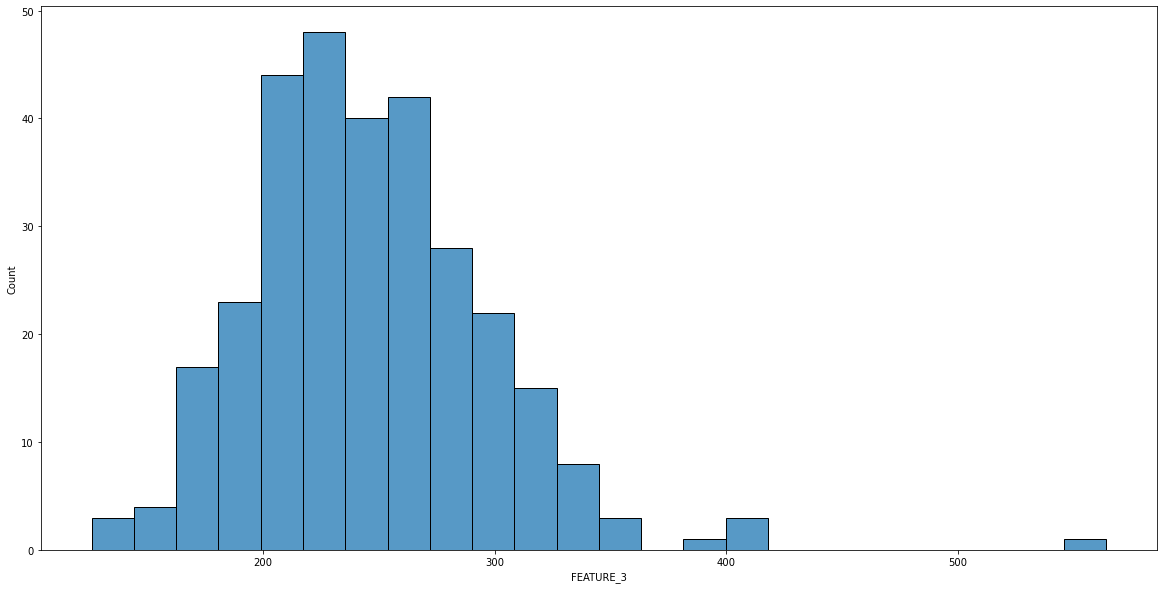

In [13]:
sns.histplot(data['FEATURE_3'])

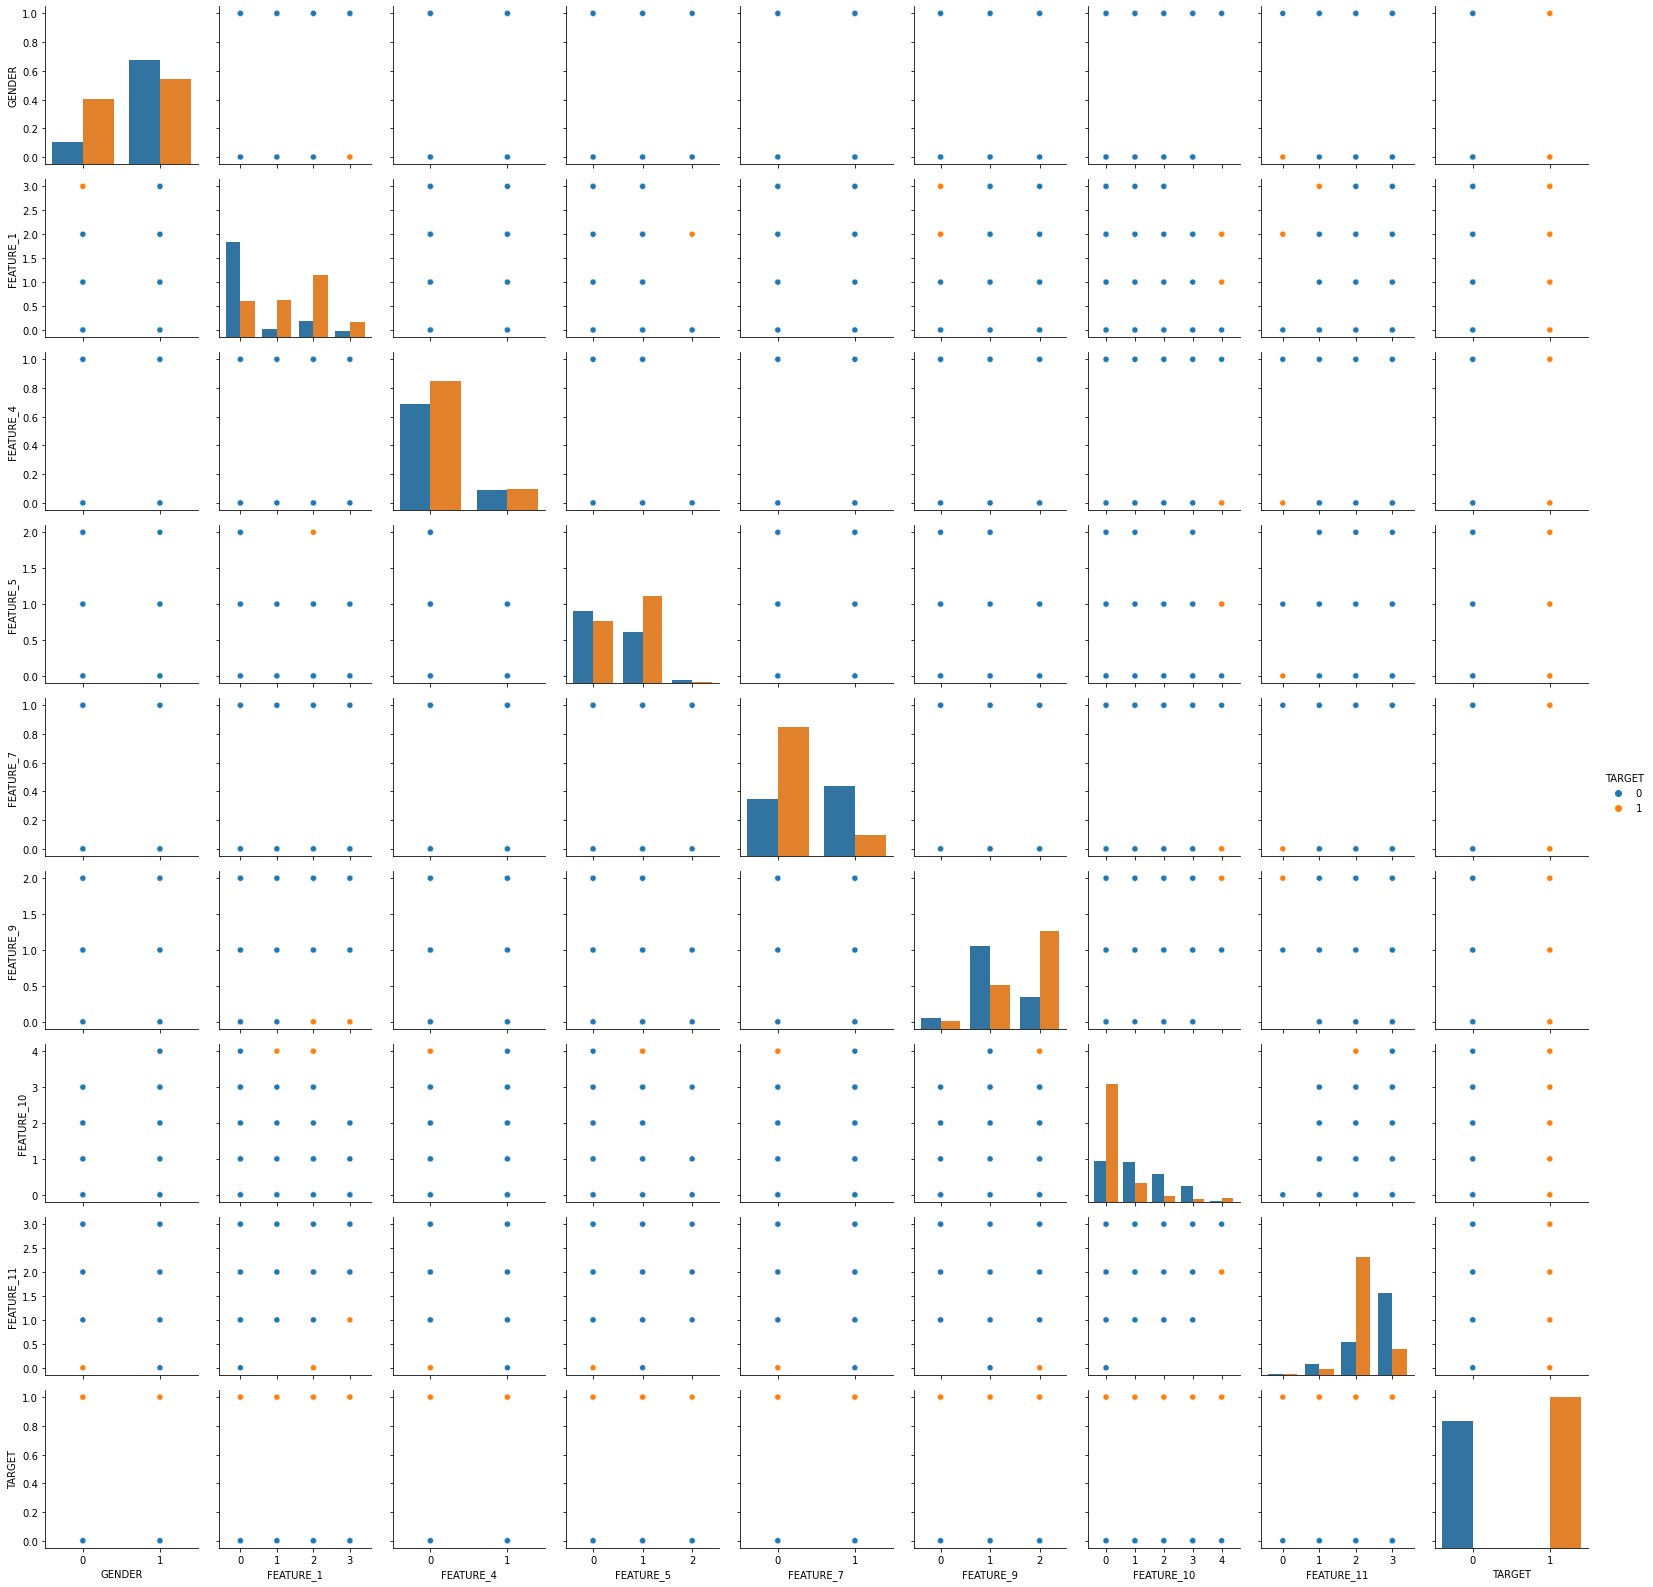

In [14]:
g = sns.PairGrid(data, vars = cat_vars, hue="TARGET")
_ = g.map_diag(sns.countplot)
_ = g.map_offdiag(sns.scatterplot)
_ = g.add_legend()

В некоторых сочетаниях категориальных переменных один класс встречается чаще другого, так что это тоже может помочь модели.

Классы почти сбалансированные, но все равно проведем стратифицированной сэмплирование при отборе отложенной, тестовой и валидационной выборок

In [15]:
data['TARGET'].value_counts()

1    164
0    138
Name: TARGET, dtype: int64

# Валидация

Будем проводить обычную Kfold валидацию на стратифицированных фолдах.\
В качестве отложенной выборки возьмем 20% от всех данных\
Из остальных данных нарежем 3 фолда, 2 из которых будут выступать в качестве валидационных, а третий в качестве тестового.

In [16]:
# Отбираем отложенную выборку (20% от всей выборки), с помощью statified split (с сохранение соотношений классов)
ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = random_state)
cv_list = list(ss.split(data, data['TARGET']))
data_test = data.iloc[cv_list[0][1]].reset_index(drop = True)
data = data.iloc[cv_list[0][0]].reset_index(drop = True)

In [17]:
X = data.drop(['TARGET'], axis = 'columns')
y = data['TARGET']

In [18]:
# Получение индексов кросс валидации
cv_list = cv.get_indices_skf(X, y, n_splits = 3, random_state = random_state)

# Подбор модели

Как обучаем модель:
1. Выбираем множество параметров0, которые хотим оптимизировать
2. С помощью optuna оптимизируем параметры
3. На каждой итерации оптимизации параметров обучаем модель на первых двух фолдах, смотрим на среднюю метрику по ним и стандартное отклонение метрики между этими двумя фолдами. Также обучаем модель и смотрим на метрику на тестовой части. Следим, чтобы средняя метрика на валидационной и тестовой частях была примерно одинакова, а также стандартное отклонение метрики между этими двумя валидационными фолдами было маленьким. Это поможет избежать переобучения и поможет обучить устойчивую модель.
4. В качестве результата итерации берем среднее значение метрики на двух валидационных фолдах
5. Повторяем эти шаги N раз, подбирая оптимальные параметры.

In [19]:
%%capture
def params_func(trial, X):
    return(
        {
            # Метрика, которую будет минимизировать модель (использование другой функции потерь может помочь преодолеть 
            # локальные минимумы во время градиентного спуска)
            'objective': 'binary', 
            # Метрика, которую будем оптимизировать при подборе параметров (и делать early stopping в lgb)
            'validation_loss': f1_score,
            'n_jobs': -1,
            # Максимальное кол-во итераций градиентного бустинга в lgbm
            'n_estimators': 1500,
            'early_stopping_rounds': 10,
            'random_state': random_state,
            # Категориальные фичи
            'categorical_feature': ['GENDER',
                                    'FEATURE_1',
                                    'FEATURE_4',
                                    'FEATURE_5',
                                    'FEATURE_7',
                                    'FEATURE_9',
                                    'FEATURE_10',
                                    'FEATURE_11'],
            'feature_name': ['AGE', 'GENDER', 'FEATURE_1', 'FEATURE_2', 'FEATURE_3', 'FEATURE_4',
                             'FEATURE_5', 'FEATURE_6', 'FEATURE_7', 'FEATURE_8', 'FEATURE_9',
                             'FEATURE_10', 'FEATURE_11'],
            # На какой подвыборке будет обучаться каждое дерево
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 1),
            # На какой подвыборке фичей будет обучаться каждое дерево
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1),
            # Минимальное количество наблюдений в листах деревьев (ставим много, т.к. переобучение будет контролировать
            # количеством листов)
            'min_child_samples': 10**1000,
            # Максимальное количество листов в каждом дереве
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.5)
        }
    )

# Инициализируем класс, подбирающий параметры
# n_trials - сколько будет попыток при выборе параметров, оптимизирующих метрику
# optuna.samplers.TPESampler сэмплировать параметры будем с помощью tree parzen estimator
my_training = model_selection_classification.training(direction = 'maximize', model = 'lgbm',
                                       params_func = params_func, n_trials = 50,
                                       random_state = random_state, sampler = optuna.samplers.TPESampler)
# Инициализируем эксперимент на neptune.ai
my_training.initiate_neptune_exp(name = 'CLassification.LGBM', 
                                 description = 
                                "['AGE', 'GENDER', 'FEATURE_1', 'FEATURE_2', 'FEATURE_3', 'FEATURE_4',\
       'FEATURE_5', 'FEATURE_6', 'FEATURE_7', 'FEATURE_8', 'FEATURE_9',\
       'FEATURE_10', 'FEATURE_11']"
                                )

# Находим оптимальные параметры
my_training.train(X = X, 
                  y = y, 
                  cv = cv_list)

[I 2021-05-25 01:35:39,475] A new study created in memory with name: no-name-10f6c3f5-2fb6-46dd-afa4-0738b2737314
[I 2021-05-25 01:35:40,461] Trial 0 finished with value: 0.7912087912087913 and parameters: {'bagging_fraction': 0.9125243741618375, 'feature_fraction': 0.6275865878278081, 'num_leaves': 203, 'learning_rate': 0.6503793470360336}. Best is trial 0 with value: 0.7912087912087913.
[I 2021-05-25 01:35:40,962] Trial 1 finished with value: 0.8172043010752688 and parameters: {'bagging_fraction': 0.5475828323461884, 'feature_fraction': 0.41932369587670204, 'num_leaves': 23, 'learning_rate': 1.168643428954764}. Best is trial 1 with value: 0.8172043010752688.
[I 2021-05-25 01:35:41,266] Trial 2 finished with value: 0.7747747747747746 and parameters: {'bagging_fraction': 0.4940601862857099, 'feature_fraction': 0.06002537432948098, 'num_leaves': 139, 'learning_rate': 0.0717894576215363}. Best is trial 1 with value: 0.8172043010752688.
[I 2021-05-25 01:35:41,392] Trial 3 finished with va

[I 2021-05-25 01:35:46,766] Trial 28 finished with value: 0.742857142857143 and parameters: {'bagging_fraction': 0.1151959268603136, 'feature_fraction': 0.024222494507545628, 'num_leaves': 120, 'learning_rate': 0.99354692103926}. Best is trial 26 with value: 0.8247422680412373.
[I 2021-05-25 01:35:46,974] Trial 29 finished with value: 0.7878787878787878 and parameters: {'bagging_fraction': 0.2148269675724972, 'feature_fraction': 0.35191731464078413, 'num_leaves': 80, 'learning_rate': 0.7396019467511945}. Best is trial 26 with value: 0.8247422680412373.
[I 2021-05-25 01:35:47,140] Trial 30 finished with value: 0.7422680412371134 and parameters: {'bagging_fraction': 0.09596047238301114, 'feature_fraction': 0.18095056910713098, 'num_leaves': 46, 'learning_rate': 0.5278858845445793}. Best is trial 26 with value: 0.8247422680412373.
[I 2021-05-25 01:35:47,297] Trial 31 finished with value: 0.7676767676767676 and parameters: {'bagging_fraction': 0.542009354303999, 'feature_fraction': 0.30707

# Результаты:

In [20]:
results = pd.read_csv('results.csv', nrows = 2)

In [21]:
results

,Id,logs/best_mean_cv_score,Description,Name,logs/metric_std_cv,logs/metric_test
0,MAG-115,0.821969,Все фичи (категориальные в dummy),Classification.SVC,0.029,0.81
1,MAG-114,0.824742,"['AGE', 'GENDER', 'FEATURE_1', 'FEATURE_2', 'F...",CLassification.LGBM,0.000,0.69


Mag-115. Supported vector classifier на всех данных с дами фичами\
Mag-114. LGB на всех данных.

Метрики примерно одинаковые, но у LGB на валидационной выборке меньше дисперсия.\
Я выберу SVC модель, т.к. у lgb лучшая метрика достигается при обучении модели на 1 итерации. Скорее всего такая модель плохо обобщает зависимости и будет нестабильно работать

Обучим модель на подобранных оптимальных параметрах

In [33]:
params = {'degree': 5, 
          'kernel': 'linear', 
          'gamma': 'scale', 
          'coef0': 3.813208780964351, 
          'C': 32.19672828908517,
          'random_state': random_state,
          'probability': True}
best_threshold = 0.367346

Обучаем на всех данных, кроме отложенной выборки

In [23]:
model = SVC(**params)
# Переводим категориальные фичи в дамми колонки
X = pd.get_dummies(X, 
                   columns = [col for col in cat_vars if col != 'TARGET'])
model.fit(X, y)

SVC(C=32.19672828908517, coef0=3.813208780964351, degree=5, kernel='linear',
    probability=True, random_state=54321)

Предсказываем на отложенной выборке

In [31]:
X_test = pd.get_dummies(data_test.drop(['TARGET'], axis = 'columns'), 
                        columns = [col for col in cat_vars if col != 'TARGET'])
# В отложенной выборке этой фичи нет, а в обучающей была, поэтому добавим эту фичу и заполним нулями
X_test['FEATURE_11_0'] = 0
# Делаем предсказания
predictions = model.predict_proba(X_test)

In [35]:
# Переводим вероятности в классы на основе подобранного порога
predictions_labels = np.where(predictions[:, 1]>best_threshold, 1, 0)

На отложенной выборке модель показывает примерно такой же score, как и на валидационной и тестовой, то есть дает устойчивый результат

In [36]:
f1_score(data_test['TARGET'], predictions_labels)

0.7792207792207791